In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [212]:
g2_gas = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/gas/g2.npy')
g2_liquid = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/liquid/g2.npy')

In [213]:
gas_rdf, gas_dist = g2_gas[:, 0], g2_gas[:, 1] 
liquid_rdf, liquid_dist = g2_liquid[:, 0], g2_liquid[:, 1] 

In [214]:
def compute_corre2(coords, L, R_max, num_bins, num_atoms):
    counts = np.zeros(num_bins)
    del_r = R_max / num_bins
    coords = coords % L
    for i in range(num_atoms-1):
        ctr_coords = coords[i]
        for j in range(i+1, num_atoms):
            r_ij = coords[j] - ctr_coords
            r_ij -= L * np.round(r_ij / L)
            dist_ij = np.sqrt(np.sum(r_ij ** 2))
            if dist_ij >= R_max:
                continue
            bin_i = int(dist_ij / del_r)
            counts[bin_i] += 2
    return counts
def compute_distances(R_max, num_bins):
    return np.linspace(0, R_max, num_bins + 1)

def compute_bin_volumes(R_max, num_bins):
    radial_dists = compute_distances(R_max, num_bins)
    volumes = 4 * np.pi / 3 * (radial_dists[1:]**3 - radial_dists[:-1]**3)
    return volumes


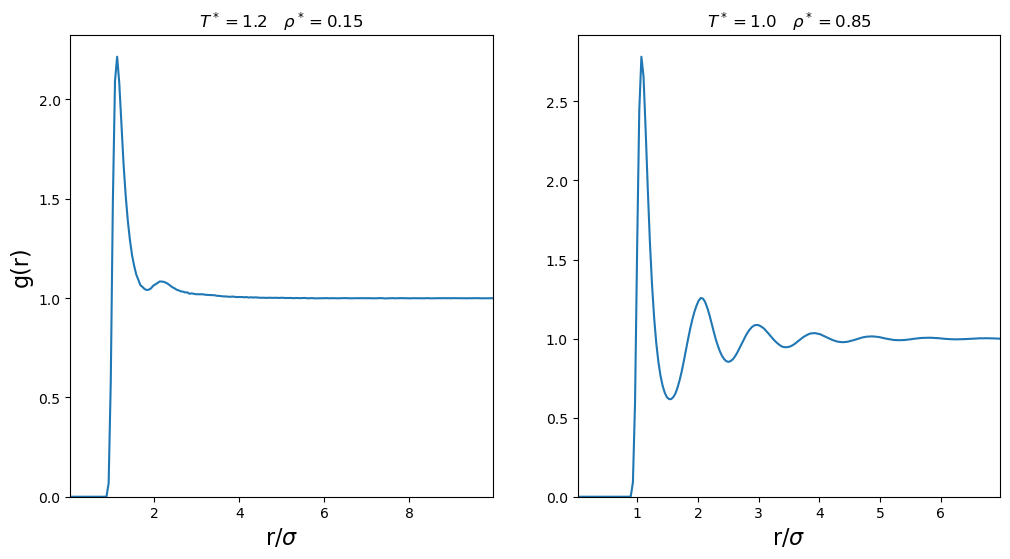

In [215]:
# Plot the RDFs side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(gas_dist, gas_rdf, label='Gas')
plt.xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
plt.ylabel('g(r)', fontsize=16)
plt.xlim(gas_dist[0], gas_dist[-1])
plt.ylim(0, None)
plt.title(r'$T^*=1.2 \ \ \ \rho ^*=0.15 $')


plt.subplot(1, 2, 2)
plt.plot(liquid_dist, liquid_rdf, label='Liquid')
plt.xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
plt.xlim(liquid_dist[0], liquid_dist[-1])
plt.ylim(0, None)
plt.title(r'$T^*=1.0 \ \ \ \rho ^*=0.85 $')
plt.show()


In [216]:
# Calculate the excess entropy integrand as a function of r 
def compute_S2_cumulative(distances, g2, density, tol=1e-6):
    """
    Compute the cumulative per-particle 2-body excess entropy S2.

    Parameters:
    distances (ndarray): Array of distance values.
    g2 (ndarray): Radial distribution function values corresponding to the distances.
    density (float): Number density of particles.
    tol (float): Tolerance value to filter rdf values considered as zero (default is 1e-6).

    Returns:
    ndarray: The computed cumulative per-particle 2-body excess entropy S2.
    """
    if len(distances) != len(g2):
        raise ValueError("distances and rdf must have the same length.")

    dr = (distances[1] - distances[0])/2
    mask = g2 > tol
    integrand = np.where(mask, (g2 * np.log(g2) - g2 + 1), 0) * distances**2
    cum_int = np.zeros(len(distances))
    cum_int[0] = integrand[0]
    for i in range(1, len(distances)-1):
        cum_int[i] = cum_int[i-1] + 2*integrand[i]
    cum_int[-1] = cum_int[-2] + integrand[-1]
    cum_int *= dr 
    cum_S2 = -2 * np.pi * density * cum_int
    return cum_S2


def compute_S2(distances, g2, density, tol=1e-6):
    """
    Compute the per-particle 2-body excess entropy S2.

    Parameters:
    distances (ndarray): Array of distance values.
    g2 (ndarray): Radial distribution function values corresponding to the distances.
    density (float): Number density of particles.
    tol (float): Tolerance value to filter rdf values considered as zero (default is 1e-6).

    Returns:
    float: The computed per-particle 2-body excess entropy S2.
    """
    if len(distances) != len(g2):
        raise ValueError("distances and rdf must have the same length.")

    dr = distances[1] - distances[0]
    mask = g2 > tol
    integrand = np.where(mask, (g2 * np.log(g2) - g2 + 1), 0) * distances**2
    integral = np.trapz(integrand, dx=dr)
    S2 = -2 * np.pi * density * integral
    return S2

In [217]:
S2_gas = compute_S2_cumulative(gas_dist, gas_rdf, 0.15)
S2_liquid = compute_S2_cumulative(liquid_dist, liquid_rdf, 0.85)

# We take the final value of the cumulative S2 as the 'ground truth' value
S2_gas_final = S2_gas[-1]
S2_liquid_final = S2_liquid[-1]


/var/folders/fl/w5ry88r17k36zgmfz_00htzh0000gn/T/ipykernel_24192/1525549177.py:20: RuntimeWarning: divide by zero encountered in log
  integrand = np.where(mask, (g2 * np.log(g2) - g2 + 1), 0) * distances**2
/var/folders/fl/w5ry88r17k36zgmfz_00htzh0000gn/T/ipykernel_24192/1525549177.py:20: RuntimeWarning: invalid value encountered in multiply
  integrand = np.where(mask, (g2 * np.log(g2) - g2 + 1), 0) * distances**2


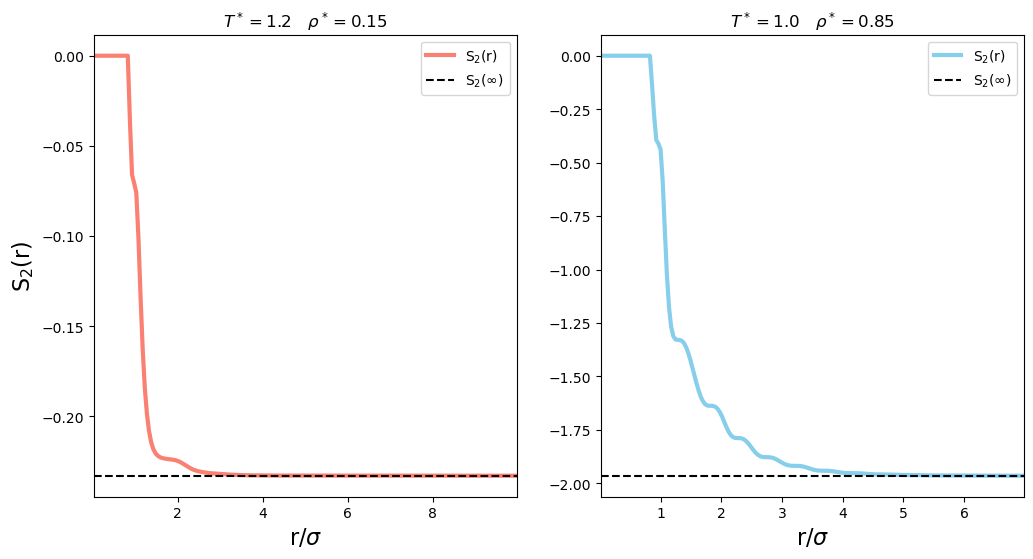

In [218]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(gas_dist, S2_gas, label=r'$\mathsf{S}_2(\mathsf{r})$', color='salmon', linewidth=3)
plt.plot(gas_dist, np.ones_like(gas_dist) * S2_gas_final, '--', color='black', label=r'$\mathsf{S}_2(\infty)$')
plt.xlim(gas_dist[0], gas_dist[-1])
plt.xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
plt.ylabel(r'$\mathsf{S}_2(\mathsf{r})$', fontsize=16)
plt.legend()
plt.title(r'$T^*=1.2 \ \ \ \rho ^*=0.15 $')

plt.subplot(1, 2, 2)
plt.plot(liquid_dist, S2_liquid, label=r'$\mathsf{S}_2(\mathsf{r})$', color='skyblue', linewidth=3)
plt.plot(liquid_dist, np.ones_like(liquid_dist) * S2_liquid_final, '--', color='black', label=r'$\mathsf{S}_2(\infty)$')
plt.xlim(liquid_dist[0], liquid_dist[-1])
plt.xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
plt.title(r'$T^*=1.0 \ \ \ \rho ^*=0.85 $')
plt.legend()
plt.show()


In [219]:
S2_gas_conv = S2_gas/S2_gas_final
S2_liquid_conv = S2_liquid/S2_liquid_final

# Find the point where it is .99 percent converged 
gas_conv_idx = np.argmax(S2_gas_conv >= 0.99)
liquid_conv_idx = np.argmax(S2_liquid_conv >= 0.99)

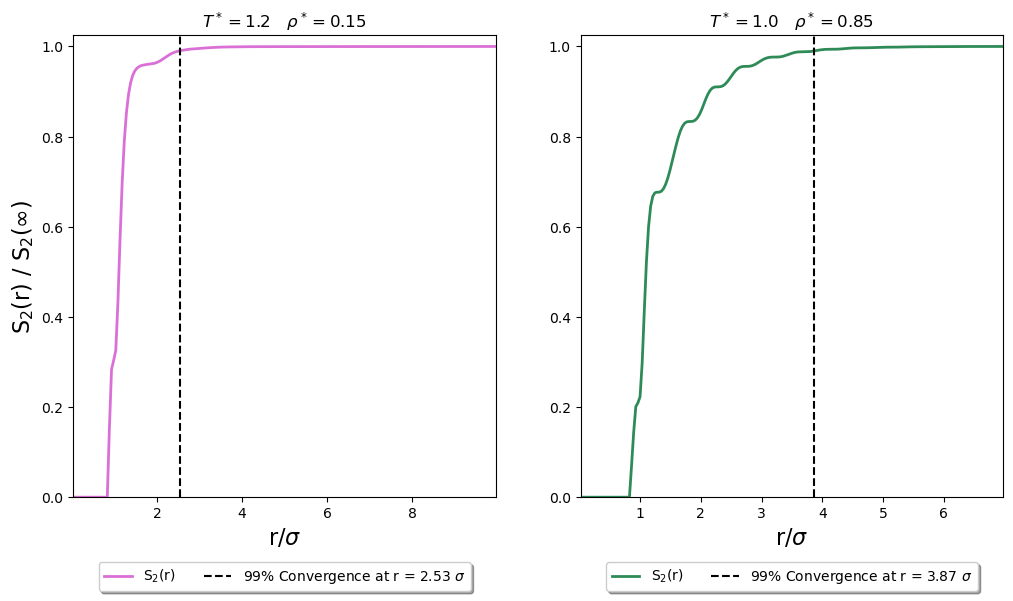

In [220]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(gas_dist, S2_gas_conv, label=r'$\mathsf{S}_2(\mathsf{r})$', color='orchid', linewidth=2)
# Vertical line at 0.99
plt.axvline(x=gas_dist[gas_conv_idx], color='black', linestyle='--', label='99% Convergence at r = {:.2f} $\sigma$'.format(gas_dist[gas_conv_idx]))
plt.xlim(gas_dist[0], gas_dist[-1])
plt.ylim(0, 1.025)
plt.xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
plt.ylabel(r'$\mathsf{S}_2(\mathsf{r}) \ / \ \mathsf{S}_2(\infty)$', fontsize=16)
plt.title(r'$T^*=1.2 \ \ \ \rho ^*=0.15 $')
# Place legend under the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), shadow=True, ncol=2)

plt.subplot(1, 2, 2)
plt.plot(liquid_dist, S2_liquid_conv, label=r'$\mathsf{S}_2(\mathsf{r})$', color='seagreen', linewidth=2)
# Vertical line at 0.99
plt.axvline(x=liquid_dist[liquid_conv_idx], color='black', linestyle='--', label='99% Convergence at r = {:.2f} $\sigma$'.format(liquid_dist[liquid_conv_idx]))
plt.xlim(liquid_dist[0], liquid_dist[-1])
plt.ylim(0, 1.025)
plt.xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
plt.title(r'$T^*=1.0 \ \ \ \rho ^*=0.85 $')
# Place legend under the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), shadow=True, ncol=2)
plt.show()




In [228]:
msd_gas = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/gas/msd.npy')
msd_liquid = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/liquid/msd.npy')
D_gas = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/gas/D.npy')
D_liquid = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/liquid/D.npy')
rho_gas, rho_liquid = 0.15, 0.85
T_gas, T_liquid = 1.2, 1.0

D_gas_rs = rho_gas**(1/3) * T_gas**(-1/2) * D_gas
D_liquid_rs = rho_liquid**(1/3) * T_liquid**(-1/2) * D_liquid

In [233]:
# Fit expontial model of D_rs vs. S2 
y = np.array([D_gas_rs, D_liquid_rs])
x = np.array([S2_gas_final, S2_liquid_final])
y_log = np.log(y)


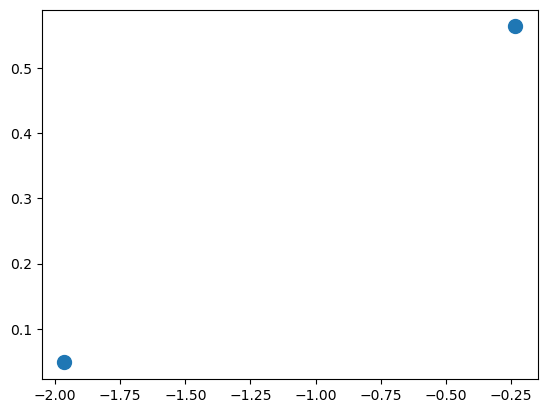

In [232]:
plt.plot([S2_gas_final, S2_liquid_final], [D_gas_rs, D_liquid_rs], 'o', markersize=10)